In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import rain

In [21]:
df = pd.read_csv(rain.toRelPath("data/df-cache.csv"))

mid = df["mid"]

In [ ]:
df = pd.read_csv(rain.toRelPath("data/bitstamp-usd.csv"), header = None)

print(df)
mid = df[1]
print(mid)

In [22]:
def portfolioToValue(fees, mid, portfolio):
    midShift = mid.shift(-1)
    rMid = midShift / mid
    rValue = portfolio * rMid
    rValue[rValue == 0] = 1
    trueValue = rValue.cumprod() * mid[0]
    
    dPortfolio = portfolio.shift(-1) - portfolio
    #percentage fees incurred at each timestep
    dRelValueFees = 1 - dPortfolio.abs() * fees
    #value with fees relative to value without fees
    relValueFees = dRelValueFees.cumprod()
    return relValueFees * trueValue

In [23]:
def mvacToPortfolio(shortPeriod, longPeriod, mid, actionThreshold):
    mvAve = [mid.rolling(shortPeriod).mean(), mid.rolling(longPeriod).mean()]
    mvDiff = mvAve[1] - mvAve[0]
    stdMvDiff = mvDiff / mvDiff.idxmax()
    #reduced using threshold
    redStdMvDiff = pd.DataFrame(np.zeros(len(df)))[0]
    redStdMvDiff[stdMvDiff > actionThreshold] = 1
    redStdMvDiff[stdMvDiff < -actionThreshold] = -1
    redStdMvDiff[redStdMvDiff == 0] = None
    threshPort = 1 - (redStdMvDiff.fillna(method = "pad") + 1) / 2
    return threshPort.fillna(value = 0)

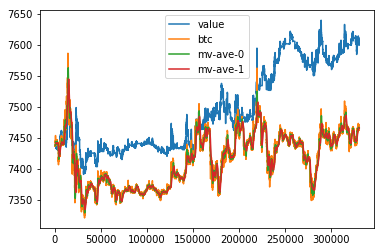

In [24]:
PERIODS = [400, 1200]

portfolio = mvacToPortfolio(PERIODS[0], PERIODS[1], mid, 0)
value = portfolioToValue(0, mid, portfolio)

plt.plot(value, label = "value")
plt.plot(mid, label = "btc")
plt.plot(mid.rolling(PERIODS[0]).mean(), label = "mv-ave-0")
plt.plot(mid.rolling(PERIODS[1]).mean(), label = "mv-ave-1")
plt.legend()
plt.show()

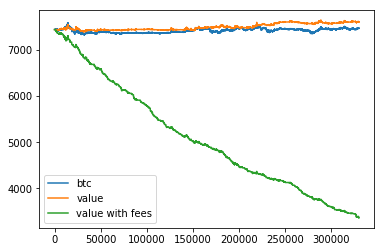

In [25]:
FEE_RATIO = 25 * 1e-4

valueFees = portfolioToValue(FEE_RATIO, mid, portfolio)

plt.plot(mid, label = "btc")
plt.plot(value, label = "value")
plt.plot(valueFees, label = "value with fees")
plt.legend()
plt.show()

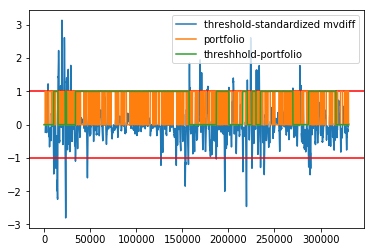

In [26]:
ACTION_THRESHOLD = 6 * 1e-4

mvDiff = mid.rolling(PERIODS[1]).mean() - mid.rolling(PERIODS[0]).mean()
threshPort = mvacToPortfolio(PERIODS[0], PERIODS[1], mid, ACTION_THRESHOLD)
plt.plot(mvDiff / mvDiff.idxmax() / ACTION_THRESHOLD, 
         label = "threshold-standardized mvdiff")
plt.axhline(y = 1, color = "r")
plt.axhline(y = -1, color = "r")
plt.plot(portfolio, label = "portfolio")
plt.plot(threshPort, label = "threshhold-portfolio")
plt.legend()
plt.show()

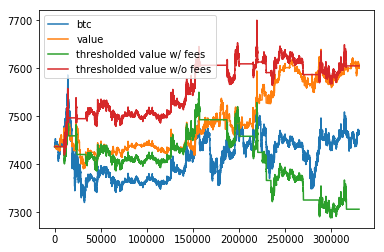

In [27]:
threshValueFees = portfolioToValue(FEE_RATIO, mid, threshPort)

plt.plot(mid, label = "btc")
plt.plot(value, label = "value")
plt.plot(threshValueFees, label = "thresholded value w/ fees")
plt.plot(portfolioToValue(0, mid, threshPort), label = "thresholded value w/o fees")
plt.legend()
plt.show()